<b><h1 style="margin-bottom:-2px;text-align:center;">Facial Recognition and Identification for ABC</h1></b>
<p style="text-align:center;">
Final Project  - Synopsis <br>
By: Alireza Akramian Arani, Damien Liscio, Garnett Grant, James Yan, Jordi Llobet Ferre <br>
Professor: Vijayalakshmi Tiruchengode Angamuthu <br>
Centennial College - F24 - COMP257 - SEC.402 - Group 4<br>
</p>

<b><h2 style="margin-bottom:0px;">Description</h2></b>
In this Project, We have been approached by a law enforcement security company ABC that would like to incorporate facial recognition and identification into their system. ABC has provided our team with the <a href="https://cs.nyu.edu/~roweis/data/umist_cropped.mat"><u>umist_cropped.mat</u></a> dataset to train our system 

In [26]:
import scipy.io as sio  # for loading matlab files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

import warnings

In [27]:
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

<b><h2 style="margin-bottom:0px;">Training</h2></b>
1. Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set. Provide your rationale for the split ratio

<h3>Function - Organize Data and Flatten in Dataframe</h3>

<b>Data from Supported Documentation</b>
* Link - https://cs.nyu.edu/~roweis/data.html
* Grayscale Faces - 8 bit [0-255]
* 20 Different People
* 575 Total Images
* Size - 112 x 92


<b>Findings/Notes in Data Exploration</b>
* Dictionary When Loading
    * "dirname" - classification per group of images
    * "facedat" - groups of images per person
* Values Stored/Wrapped in Object Array
    * Third Value in Shapes Represent Instances of Image per Person
* Classification Values are String Values; Converted to Numerical Values for Efficiency/Simplicity
* Flattened Data Feature Length - 10304 (112 x 92)
* Converted Data to Dataframe for Clarity
* Appended Numerical Classification to Dataframe - "target"


In [28]:
def organizeData(file_path):
    
    # Import Data
    dataset = sio.loadmat(file_path)
    
    # Seperate Data (class/face position) 
    classification = dataset['dirnames']
    face_data = dataset['facedat']
    
    # Transform Classifications to Numerical
    for i in range(len(classification[0])):
        classification[0][i] = i
    
    # Create an empty list to append to dataframe later on
    face_data_list = []
    class_list = []
    
    
    # Grab Image and Classification Per Person
    for person_i in range(len(face_data[0])):                                                  # [0] -> Index to Get First Row to Access Data Directly
        print("==============================================================")
        print(f"Number of Images for Person {person_i}: {face_data[0][person_i].shape[2]}")                                                     
        
        for face_i in range(face_data[0][person_i].shape[2]):                                     
            # Verification and Visualization
            """
            print(face_data[0][person_i][:, :, face_i].shape)
            plt.imshow(face_data[0][person_i][:, :, face_i])
            plt.xticks([])
            plt.yticks([])
            plt.show()
            """
            # Append Data
            face_data_list.append(face_data[0][person_i][:, :, face_i].reshape(-1))             # Append Face Pics in Single Line
            class_list.append(str(classification[0][person_i]))                                 # Append Numerical Class Per Person

    
    data_org = pd.DataFrame(face_data_list)
    data_org['target'] = class_list

    return data_org

In [29]:
df_organized = organizeData('umist_cropped.mat')
df_organized.head()

Number of Images for Person 0: 38
Number of Images for Person 1: 35
Number of Images for Person 2: 26
Number of Images for Person 3: 24
Number of Images for Person 4: 26
Number of Images for Person 5: 23
Number of Images for Person 6: 19
Number of Images for Person 7: 22
Number of Images for Person 8: 20
Number of Images for Person 9: 32
Number of Images for Person 10: 34
Number of Images for Person 11: 34
Number of Images for Person 12: 26
Number of Images for Person 13: 30
Number of Images for Person 14: 19
Number of Images for Person 15: 26
Number of Images for Person 16: 26
Number of Images for Person 17: 33
Number of Images for Person 18: 48
Number of Images for Person 19: 34


,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,target
0,233,234,234,233,234,232,232,168,99,78,...,154,151,147,143,140,141,141,140,136,0
1,234,234,234,234,233,232,202,98,79,77,...,154,150,147,141,140,137,138,137,137,0
2,234,234,234,234,233,230,225,109,85,84,...,174,168,164,157,152,151,148,145,145,0
3,234,234,234,234,234,234,234,232,229,205,...,168,162,157,155,150,144,144,142,143,0
4,234,234,234,234,234,234,234,234,229,211,...,176,170,164,162,157,152,150,148,148,0


<h3>Seperate Class and Features</h3>

In [30]:
target = df_organized['target']
features = df_organized.drop('target', axis=1)

<h3>View Classes (from Dataframe)</h3>

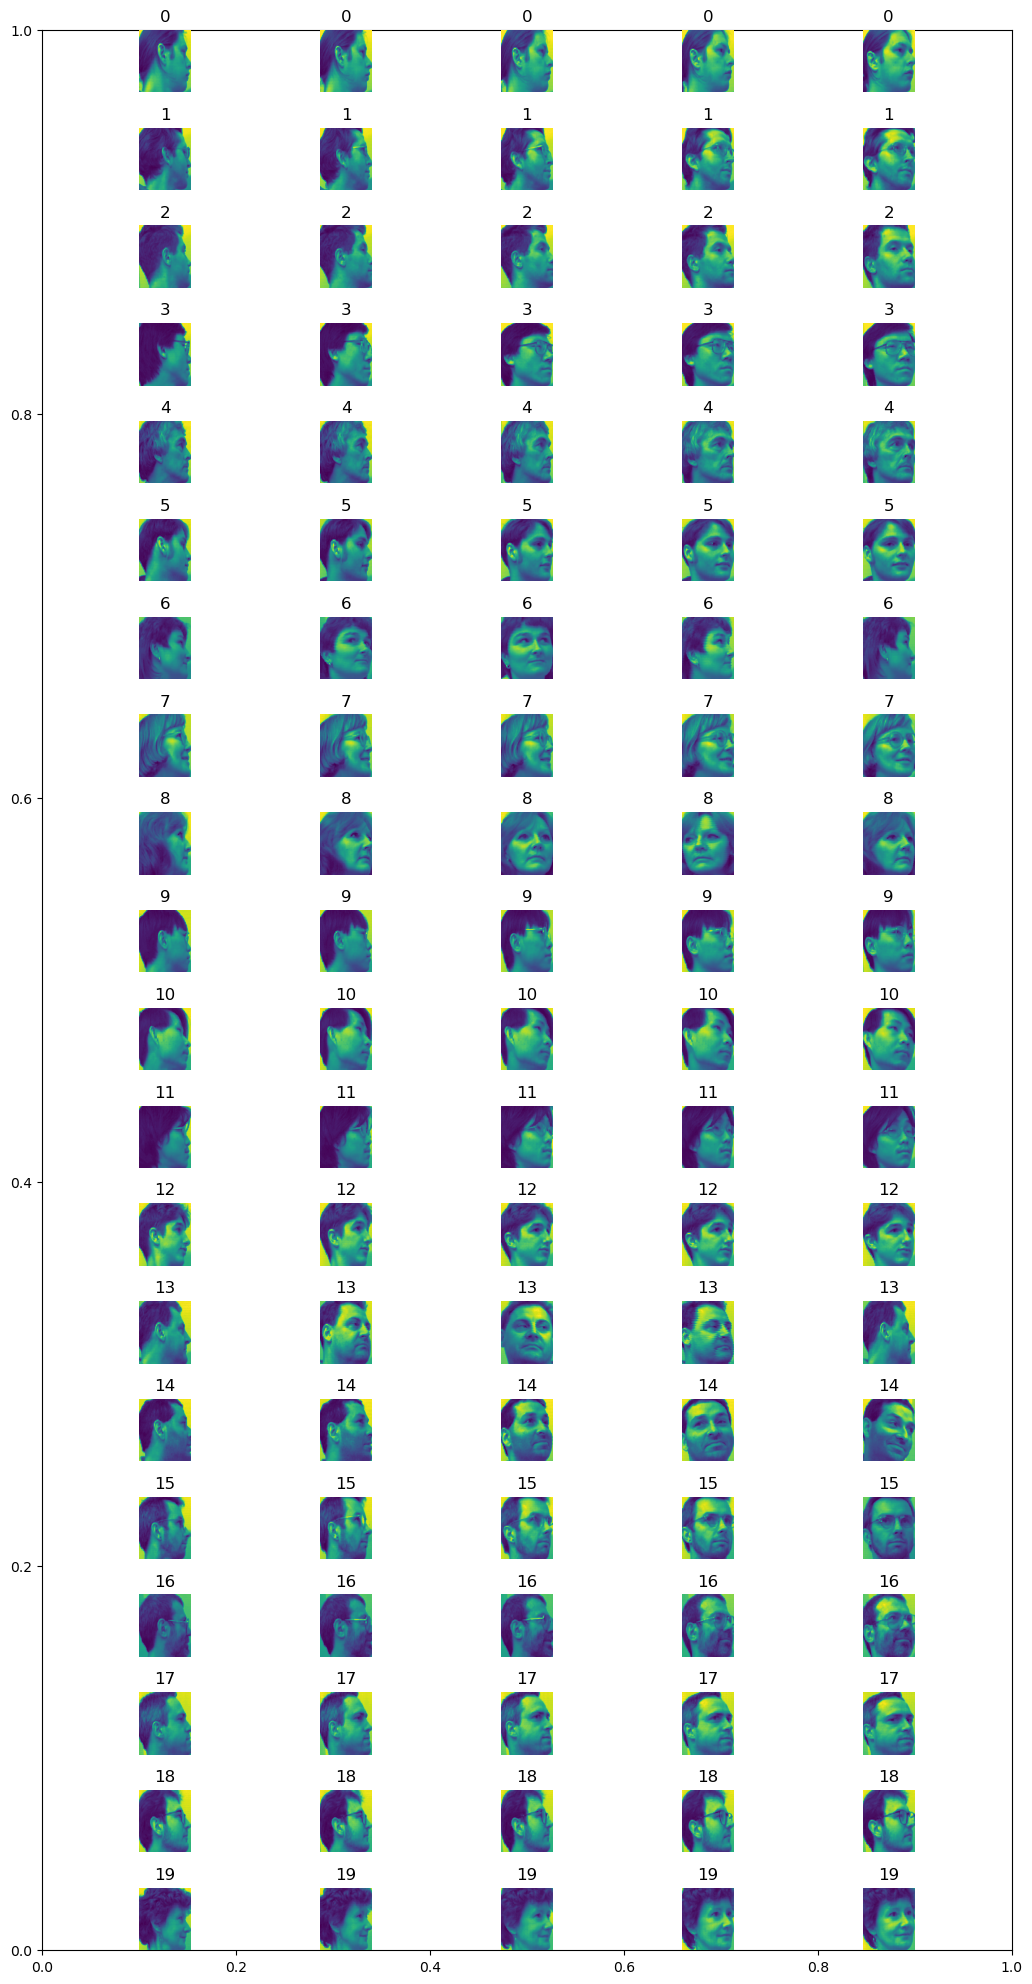

In [31]:
unique_target_var = pd.unique(target)
fig = plt.subplots(figsize=(10, 20))

grouped_indices = target.groupby(target).indices

plt_index = 0
test = None
for unique in unique_target_var:
    for num in [0, 4, 8, 12, 16]:
        plt_index += 1

        index_to_acess = grouped_indices[unique][num]
        
        plt.subplot(20, 5, plt_index) 
        
        
        plt.imshow(np.array(features.iloc[index_to_acess]).reshape(112, 92))
        plt.axis("off")
        plt.title(unique)

plt.tight_layout()
plt.show()


<h3>Stratified Split: Train, Val, Test [60/20/20 Split]</h3>

In [32]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, stratify=target, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

<b><h2 style="margin-bottom:0px;">Analysis Report</h2></b>

2. In the analysis report, discuss the rationale behind how your team preprocess the data. Include the mathematical equations used and any dimensionality reduction applied to the instanced and discuss its relevance to the problem at hand. (Note that your team will receive more points if you perform data preprocessing that help improve the eventual training process.)

<h3>PCA Dimensionality Reduction</h3>

In [33]:
pca = PCA(n_components=0.99)
x_train_red = pca.fit_transform(x_train)
x_test_red = pca.transform(x_test)
x_val_red = pca.transform(x_val)

<h3>Standardize Pixel Values - Not Normalize!</h3>

In [34]:
scaler = StandardScaler()
x_train_pre = scaler.fit_transform(x_train_red)
x_test_pre = scaler.transform(x_test_red)
x_val_pre = scaler.transform(x_val_red)

<h3>One Hot Encode Labels</h3>

In [35]:
one_hot_train = tf.one_hot(y_train, depth=len(y_train.unique()))
one_hot_test = tf.one_hot(y_test, depth=len(y_test.unique()))
one_hot_val = tf.one_hot(y_val, depth=len(y_val.unique()))

<b><h2 style="margin-bottom:0px;">Clustering</h2></b>

3. Select a clustering technique taught in this course and apply it on the training instances. Provide the rationale behind your team’s choice of clustering technique and how your team tuned the parameters for the technique implemented. 

<h3>kMeans - Choosing the Optimal Number of Clusters from Silhouette Score</h3>

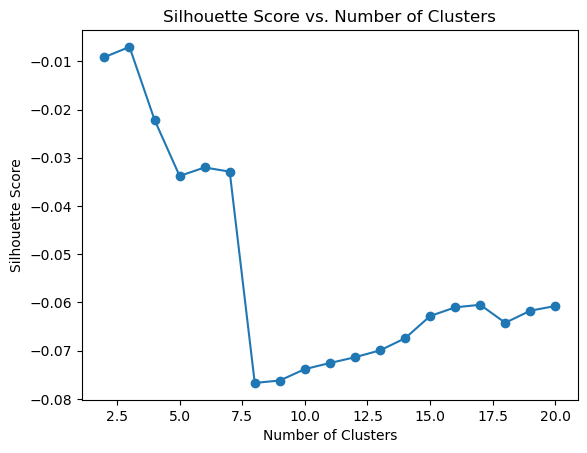

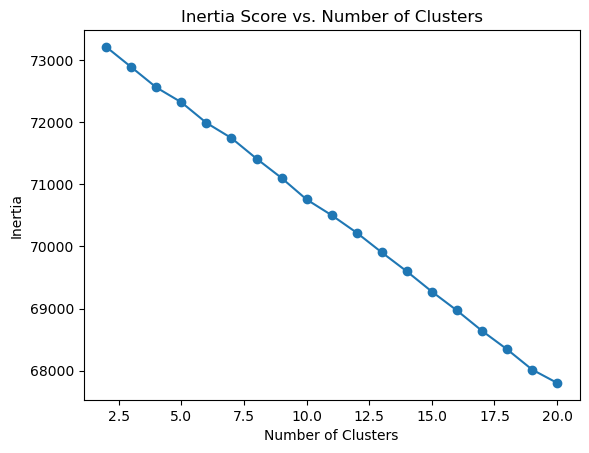

In [36]:
sil_scores = []
inertia_scores = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(x_train_pre)
    inertia_scores.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(x_train_pre, kmeans.labels_))

plt.plot(range(2, 21), sil_scores, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

plt.plot(range(2, 21), inertia_scores, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Score vs. Number of Clusters')
plt.show()

<h3>kMeans with Best Number of Clusters</h3>

In [37]:
best_kmeans = KMeans(n_clusters=3, random_state=42)
best_kmeans.fit(x_train_pre)

for i in range(3):
    unique, counts = np.unique(y_train[best_kmeans.labels_ == i], return_counts=True)
    print(f"Cluster {i}: {unique}\nNumber of Images: {sum(counts)}")

Cluster 0: ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '3' '4' '5'
 '6' '7' '8' '9']
Number of Images: 297
Cluster 1: ['0' '10' '12' '13' '14' '15' '16' '17' '18' '19' '2' '3' '5' '6' '8' '9']
Number of Images: 43
Cluster 2: ['6' '8' '9']
Number of Images: 5


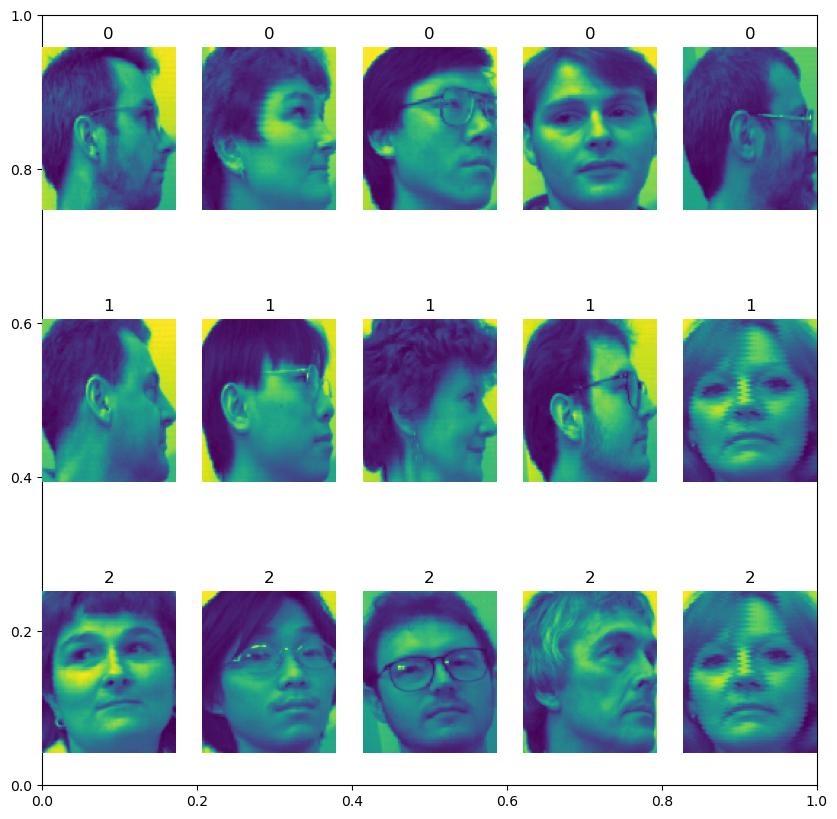

In [50]:
pred_kmodel_labels = best_kmeans.labels_

fig = plt.subplots(figsize=(10, 10))
plt_index = 0
for unique in np.unique(pred_kmodel_labels):
    cluster_indices = np.where(pred_kmodel_labels == unique)[0]
    
    for ind, num in enumerate(random.sample(range(0, cluster_indices.shape[0] + 1), 5)):
        plt_index += 1
        # Index Access Point
        image = x_train.iloc[num]

        # Subplot Image, Dimensions, and Place
        plt.subplot(3, 5, plt_index) 
        plt.imshow(np.array(image).reshape(112, 92))
        plt.axis("off")
        plt.title(unique)
            

<h3>Feature Engineering - Euclidean Distance from Centroid Features</h3>

In [17]:
x_train_k = best_kmeans.transform(x_train_pre)
x_test_k = best_kmeans.transform(x_test_pre)
x_val_k = best_kmeans.transform(x_val_pre)

<h3>Feature Engineering - Assigned Centroid Feature</h3>

In [18]:
label_train = best_kmeans.labels_
label_test = best_kmeans.predict(x_test_pre)
label_val = best_kmeans.predict(x_val_pre)

k_train_cl_oh = tf.one_hot(label_train, depth=len(np.unique(label_train)))
k_test_cl_oh = tf.one_hot(label_test, depth=len(np.unique(label_train)))
k_val_cl_oh = tf.one_hot(label_val, depth=len(np.unique(label_train)))

<h3>Concatenate to Get Final Dataset</h3>

In [19]:
x_train_transf = np.concatenate((x_train_pre, x_train_k, k_train_cl_oh), axis=1)
x_test_transf = np.concatenate((x_test_pre, x_test_k, k_test_cl_oh), axis=1)
x_val_transf = np.concatenate((x_val_pre, x_val_k, k_val_cl_oh), axis=1)

<b><h2 style="margin-bottom:0px;">Analysis Report - Architecture</h2></b>

4. In the analysis report, clearly discuss - with illustrations - the architecture your team has selected for training and predicting the test instances. Discuss the rationale behind your team’s choice of activation functions, loss function, and how you tuned the hyperparameters of the network model.

<h3>MLP Model w/ Basic Original Dataset</h3>

In [20]:
base_model = Sequential()
base_model.add(Input(shape=(x_train_pre.shape[1],)))
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(64, activation='relu'))
base_model.add(Dense(len(y_train.unique()), activation='softmax'))

base_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               27392     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
Total params: 36,948
Trainable params: 36,948
Non-trainable params: 0
_________________________________________________________________


<h3>MLP Model w/ Feature Engineered Dataset</h3>

In [21]:
k_model = Sequential()
k_model.add(Input(shape=(x_train_transf.shape[1],)))
k_model.add(Dense(128, activation='relu'))
k_model.add(Dense(64, activation='relu'))
k_model.add(Dense(len(y_train.unique()), activation='softmax'))

k_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

k_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               28160     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1300      
Total params: 37,716
Trainable params: 37,716
Non-trainable params: 0
_________________________________________________________________


<b><h2 style="margin-bottom:0px;">Results</h2></b>

5. Discuss the results of the trained system in the report.

<h3>Function for Plotting Results</h3>

In [22]:
# Function for Vader Metric Analysis
def model_metric_analyze(classification, prediction):
  ac_score = accuracy_score(classification, prediction)
  pr_score = precision_score(classification, prediction, average="weighted")
  re_score = recall_score(classification, prediction, average="weighted")
  f1_measure = f1_score(classification, prediction, average="weighted")
  cf_matrix = confusion_matrix(classification, prediction)

  custom_index = ['accuracy', 'precision', 'recall', 'f1', 'cf']
  df_scores = pd.Series([ac_score, pr_score, re_score, f1_measure, cf_matrix], index=custom_index)
  return df_scores

# Function for Outputting Metrics
def print_metrics(df_scores):
  print(f'Accuracy Score: {df_scores["accuracy"]}')
  print(f'Precision Score: {df_scores["precision"]}')
  print(f'Recall Score: {df_scores["recall"]}')
  print(f'F1 Score: {df_scores["f1"]}')

  labels = range(1, 21)
  sns.heatmap(df_scores['cf'], annot=True, fmt='d', cmap='flare', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted', fontweight='bold', fontsize=15)
  plt.ylabel('Actual', fontweight='bold', fontsize=15)
  plt.title('Confusion Matrix', fontweight='bold', fontsize=20)
  plt.show()

<h3>MLP Model w/ Basic Original Dataset</h3>

<h4>Training w/ Validation</h4>

In [23]:
base_model.fit(x_train_pre, one_hot_train, epochs=50, validation_data=(x_val_pre, one_hot_val)) 

Epoch 1/50
11/11 [==============================] - 2s 11ms/step - loss: 3.1318 - accuracy: 0.0609 - val_loss: 2.8911 - val_accuracy: 0.1130
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 2.5927 - accuracy: 0.2754 - val_loss: 2.6569 - val_accuracy: 0.2696
Epoch 3/50
11/11 [==============================] - 0s 2ms/step - loss: 2.2215 - accuracy: 0.5652 - val_loss: 2.4429 - val_accuracy: 0.4087
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 1.8581 - accuracy: 0.6986 - val_loss: 2.2209 - val_accuracy: 0.5652
Epoch 5/50
11/11 [==============================] - 0s 3ms/step - loss: 1.5029 - accuracy: 0.8580 - val_loss: 1.9791 - val_accuracy: 0.6261
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 1.1640 - accuracy: 0.9362 - val_loss: 1.7397 - val_accuracy: 0.6522
Epoch 7/50
11/11 [==============================] - 0s 2ms/step - loss: 0.8505 - accuracy: 0.9826 - val_loss: 1.5110 - val_accuracy: 0.6783
Epoch 8/50
11/11 [=

<h4>Evaluating Test Data</h4>

In [24]:
base_results = base_model.evaluate(x_test_pre, one_hot_test)
print("test loss, test acc:", base_results)

4/4 [==============================] - 0s 1000us/step - loss: 0.3611 - accuracy: 0.9391
test loss, test acc: [0.3610590994358063, 0.939130425453186]


In [25]:
# Make Predictions
base_predictions = base_model.predict(x_test_pre)

In [26]:
# Set To One Column
base_predictions_single = np.argmax(base_predictions, axis=1)
true_predictions_single = np.argmax(one_hot_test, axis=1)

Accuracy Score: 0.9391304347826087
Precision Score: 0.9545341614906833
Recall Score: 0.9391304347826087
F1 Score: 0.9415019762845849


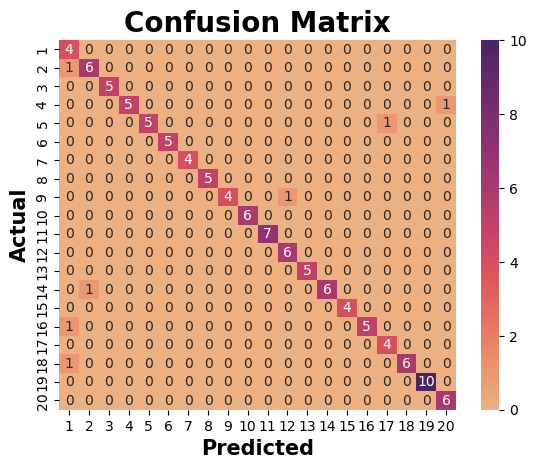

In [27]:
# Get Metrics
print_metrics(model_metric_analyze(base_predictions_single, true_predictions_single))

<h3>MLP Model w/ Basic Original Dataset</h3>

<h4>Training w/ Validation</h4>

In [28]:
k_model.fit(x_train_transf, one_hot_train, epochs=50, validation_data=(x_val_transf, one_hot_val)) 

Epoch 1/50
11/11 [==============================] - 0s 9ms/step - loss: 3.5160 - accuracy: 0.0551 - val_loss: 2.9226 - val_accuracy: 0.1043
Epoch 2/50
11/11 [==============================] - 0s 3ms/step - loss: 2.8469 - accuracy: 0.1275 - val_loss: 2.6874 - val_accuracy: 0.2174
Epoch 3/50
11/11 [==============================] - 0s 3ms/step - loss: 2.4709 - accuracy: 0.2841 - val_loss: 2.4564 - val_accuracy: 0.2870
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 2.1295 - accuracy: 0.4986 - val_loss: 2.1913 - val_accuracy: 0.4348
Epoch 5/50
11/11 [==============================] - 0s 3ms/step - loss: 1.7807 - accuracy: 0.6928 - val_loss: 1.9336 - val_accuracy: 0.5478
Epoch 6/50
11/11 [==============================] - 0s 3ms/step - loss: 1.4504 - accuracy: 0.8290 - val_loss: 1.6611 - val_accuracy: 0.6696
Epoch 7/50
11/11 [==============================] - 0s 3ms/step - loss: 1.1106 - accuracy: 0.9072 - val_loss: 1.3671 - val_accuracy: 0.7391
Epoch 8/50
11/11 [==

<h4>Evaluating Test Data</h4>

In [29]:
k_results = k_model.evaluate(x_test_transf, one_hot_test)
print("test loss, test acc:", k_results)

4/4 [==============================] - 0s 1ms/step - loss: 0.2268 - accuracy: 0.9391
test loss, test acc: [0.22682726383209229, 0.939130425453186]


In [30]:
# Get Predictions
k_predictions = k_model.predict(x_test_transf)

In [31]:
# Set To One Column
k_predictions_single = np.argmax(k_predictions, axis=1)

Accuracy Score: 0.9391304347826087
Precision Score: 0.9532608695652175
Recall Score: 0.9391304347826087
F1 Score: 0.9387926083578257


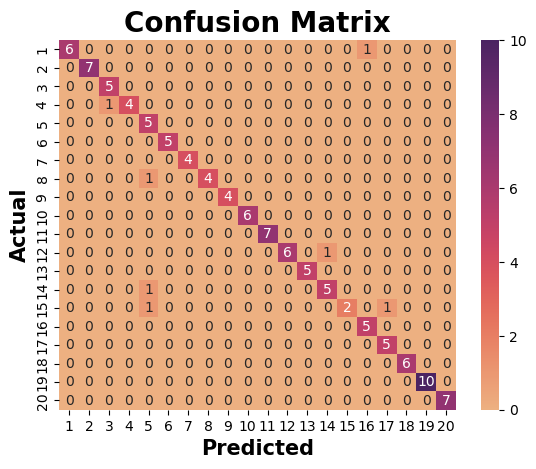

In [32]:
# Get Metrics
print_metrics(model_metric_analyze(true_predictions_single, k_predictions_single))

<b><h2>Generalizing Data and Adding Dataset for Comparison</h2></b>

<h3>Adding Additional Dataset</h3>

* To add additional dataset and add faces to make model bigger to see results.